## Dependencies

In [1]:
import os
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from src_3d.model1 import MobileNetV3UNet3D
from torchsummary import summary
import torch
from ptflops import get_model_complexity_info
from torch.profiler import profile, record_function, ProfilerActivity
import torch

# -- Change this as per your data directory --#
data_path = Path('C:\Projects\python\echoframe\data\EchoNet-Dynamic\EchoNet-Dynamic\\')


file_list_path = os.path.join(data_path,'FileList.csv')
volume_tracings_path = os.path.join(data_path,'VolumeTracings.csv')
videos_path = os.path.join(data_path,'Videos')

<>:17: SyntaxWarning: invalid escape sequence '\P'
<>:17: SyntaxWarning: invalid escape sequence '\P'
C:\Users\harsh\AppData\Local\Temp\ipykernel_29304\3670716550.py:17: SyntaxWarning: invalid escape sequence '\P'
  data_path = Path('C:\Projects\python\echoframe\data\EchoNet-Dynamic\EchoNet-Dynamic\\')
c:\Projects\python\echoframe_capstone\mainenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
file_list = pd.read_csv(filepath_or_buffer=file_list_path)
volume_tracings = pd.read_csv(filepath_or_buffer=volume_tracings_path)
file_list['FileName'] = file_list['FileName'].apply(
    lambda x: x if x.endswith('.avi') else x + '.avi'
)
vt_filenames = set(volume_tracings['FileName'])
fl_filenames = set(file_list['FileName'])

missing_files = list(fl_filenames - vt_filenames)
extra_files = list(vt_filenames - fl_filenames)

print(f'Missing files: \n{missing_files}\n\nExtra files: \n{extra_files}')
redacted_files = missing_files+extra_files
file_list = file_list[~file_list['FileName'].isin(redacted_files)]
volume_tracings = volume_tracings[~volume_tracings['FileName'].isin(redacted_files)]

Missing files: 
['0X5515B0BD077BE68A.avi', '0X6C435C1B417FDE8A.avi', '0X234005774F4CB5CD.avi', '0X35291BE9AB90FB89.avi', '0X2DC68261CBCC04AE.avi', '0X5DD5283AC43CCDD1.avi']

Extra files: 
['0X4F8859C8AB4DA9CB.avi']


In [3]:
train_df = file_list[file_list['Split'] == 'TRAIN']
val_df   = file_list[file_list['Split'] == 'VAL']
test_df  = file_list[file_list['Split'] == 'TEST']

## Load data

In [4]:
# frame_gap = []
# for files in train_df.FileName:
#     gap = np.sort(volume_tracings[volume_tracings['FileName'] == files]['Frame'].unique())
#     if len(gap)>2:
#         print(f'Three frames detected for {files}')
#         break
#     else:
#         frame_gap.append(int(np.diff(gap)[0]))


## Model

In [14]:
# model = MobileNetV3UNet3D().cuda()
# # summary(model=model,input_size=(3,32,112,112), batch_size=4,device='cuda')
# # dummy_input = torch.randn(4, 3, 32, 112, 112).cuda()
# # output = model(dummy_input)
# # print(output.shape)
# gflops = []
# model.eval()
# for t in range(16,200):
#     with torch.cuda.device(0):
#         macs, _ = get_model_complexity_info(model, (3,200, 112, 112), as_strings=True,
#                                                 print_per_layer_stat=False)
#     gflops.append([t,float(macs.split()[0])*2])
#     break



model = MobileNetV3UNet3D().cuda()
model.eval()

gflops = []

for t in range(16, 200):
    dummy_input = torch.randn(1, 3, t, 112, 112).cuda()
    
    with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA],
                 record_shapes=True,
                 profile_memory=True,
                 with_flops=True) as prof:
        with torch.no_grad():
            with record_function("model_inference"):
                _ = model(dummy_input)

    flops = prof.key_averages().total_average().flops / 1e9  # GFLOPs
    mem = prof.key_averages().total_average().self_device_memory_usage/ 1e6  # MB
    gflops.append([t, flops, mem])
    break

In [15]:
gflops

[[16, 0.01085056, 0.0]]

In [ ]:
df = pd.DataFrame(gflops, columns=['clip_length', 'Gflops'])
df.to_csv('../logs/model_complexity.csv', index=False)

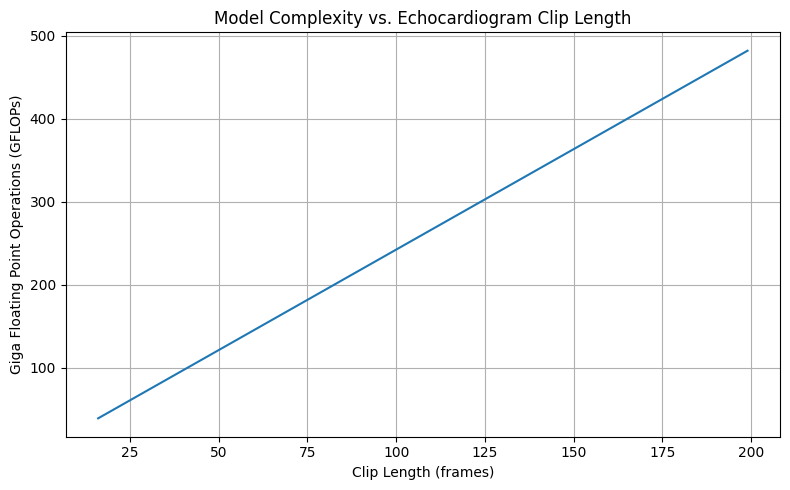

In [ ]:
# Use the correct column names for plotting
plt.figure(figsize=(8, 5))
plt.plot(df['clip_length'], df['Gflops'])
plt.title("Model Complexity vs. Echocardiogram Clip Length")
plt.xlabel("Clip Length (frames)")
plt.ylabel("Giga Floating Point Operations (GFLOPs)")
plt.grid(True)
plt.tight_layout()
plt.show()
